In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from evaluation import forecast_accuracy

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')


print(df.isna().sum())

df = df.rename(columns={'ROH_med':'ROH'})
df['DOA'] = pd.to_datetime(df['DOA'])

df['DOW'] = df['DOA'].dt.dayofweek
df['Mon'] = df['DOA'].dt.month
df['Day'] = df['DOA'].dt.day

# just to make DOA unique
df['DOA'] = df['DOA']+df['DBA'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 
df = df.set_index('DOA')

HotelId
DOA        0
DBA        0
ROH_max    0
ROH_min    0
ROH_med    0
ROH_avg    0
ROH_std    0
DOW        0
LAR_max    0
LAR_min    0
LAR_med    0
LAR_avg    0
LAR_std    0
dtype: int64


In [2]:

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

def plot_train_test(train, test):
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

def plot_result(dx):
    plt.plot(dx.index, dx['ROH'], label='test')
    plt.plot(dx.index, dx['PRED'], label='SVR')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

In [4]:
df.head()

HotelId,DBA,ROH_max,ROH_min,ROH,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,Mon,Day
DOA,,,,,,,,,,,,,,
2018-01-01 23:44:00,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 23:28:00,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 21:04:00,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:48:00,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:32:00,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.5,38.69,72.9,75.847778,30.871318,1,1


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HotelId,,,,,,,,
DBA,65700.0,44.500000,25.979356,0.000000,22.000000,44.500000,67.000000,89.000000
ROH_max,65700.0,480.852511,148.186961,47.000000,376.000000,498.000000,598.000000,791.000000
ROH_min,65700.0,13.924642,12.576373,0.000000,4.000000,10.000000,21.000000,54.000000
ROH,65700.0,39.022884,19.994039,2.000000,23.000000,37.000000,52.500000,110.500000
ROH_avg,65700.0,92.551642,32.021862,13.526316,68.052632,90.526316,115.973684,174.500000
ROH_std,65700.0,138.349289,41.205769,16.884486,109.519194,144.132324,171.031402,226.742438
DOW,65700.0,2.993151,2.001715,0.000000,1.000000,3.000000,5.000000,6.000000
LAR_max,65700.0,190.963059,68.656225,76.500000,143.650000,178.500000,220.150000,696.000000
LAR_min,65700.0,51.797365,18.114094,20.900000,40.000000,47.590000,58.370000,236.680000


## Train/Test Split

In [6]:
index = int(len(df)*0.8)
train = df[:index]
test  = df[index:]

In [7]:
df.head()

HotelId,DBA,ROH_max,ROH_min,ROH,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,Mon,Day
DOA,,,,,,,,,,,,,,
2018-01-01 23:44:00,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 23:28:00,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 21:04:00,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:48:00,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:32:00,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.5,38.69,72.9,75.847778,30.871318,1,1


In [8]:
def plot_train_test(train, test):
    train = train[train['DBA']== train['DBA'].max()]
    test = test[test['DBA']== train['DBA'].max()]
    plt.plot(train['DOA'], train['ROH'], label='Train')
    plt.plot(test['DOA'], test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

plot_train_test(train,test)

KeyError: 'DOA'

In [9]:
y = train.pop('ROH')
X = train

In [10]:
X

HotelId,DBA,ROH_max,ROH_min,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,Mon,Day
DOA,,,,,,,,,,,,,
2018-01-01 23:44:00,0.0,194.0,1.0,45.710526,65.541332,0,144.50,38.69,72.900,75.847778,30.871318,1,1
2018-01-01 23:28:00,1.0,194.0,1.0,47.368421,64.749892,0,144.50,38.69,72.900,75.847778,30.871318,1,1
2018-01-01 21:04:00,10.0,203.0,2.0,47.842105,67.742751,0,144.50,38.69,72.900,75.847778,30.871318,1,1
2018-01-01 20:48:00,11.0,203.0,3.0,48.368421,67.552872,0,144.50,38.69,72.900,75.847778,30.871318,1,1
2018-01-01 20:32:00,12.0,217.0,3.0,49.842105,70.976099,0,144.50,38.69,72.900,75.847778,30.871318,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-07 00:48:00,86.0,698.0,40.0,153.973684,194.069472,2,179.10,56.48,93.395,102.697105,40.397048,8,7
2019-08-07 00:32:00,87.0,707.0,41.0,156.921053,196.327483,2,197.10,56.48,92.800,105.522632,44.326659,8,7
2019-08-07 00:16:00,88.0,716.0,42.0,161.157895,199.053355,2,169.01,47.59,99.755,100.519737,35.868959,8,7


In [11]:
regr = RandomForestRegressor(max_depth=1000, random_state=0)
regr.fit(X, y)

RandomForestRegressor(max_depth=1000, random_state=0)

In [12]:
test_predict_cols = [attr for attr in test.columns if attr!='ROH']
test['PRED']  = regr.predict(test[test_predict_cols])

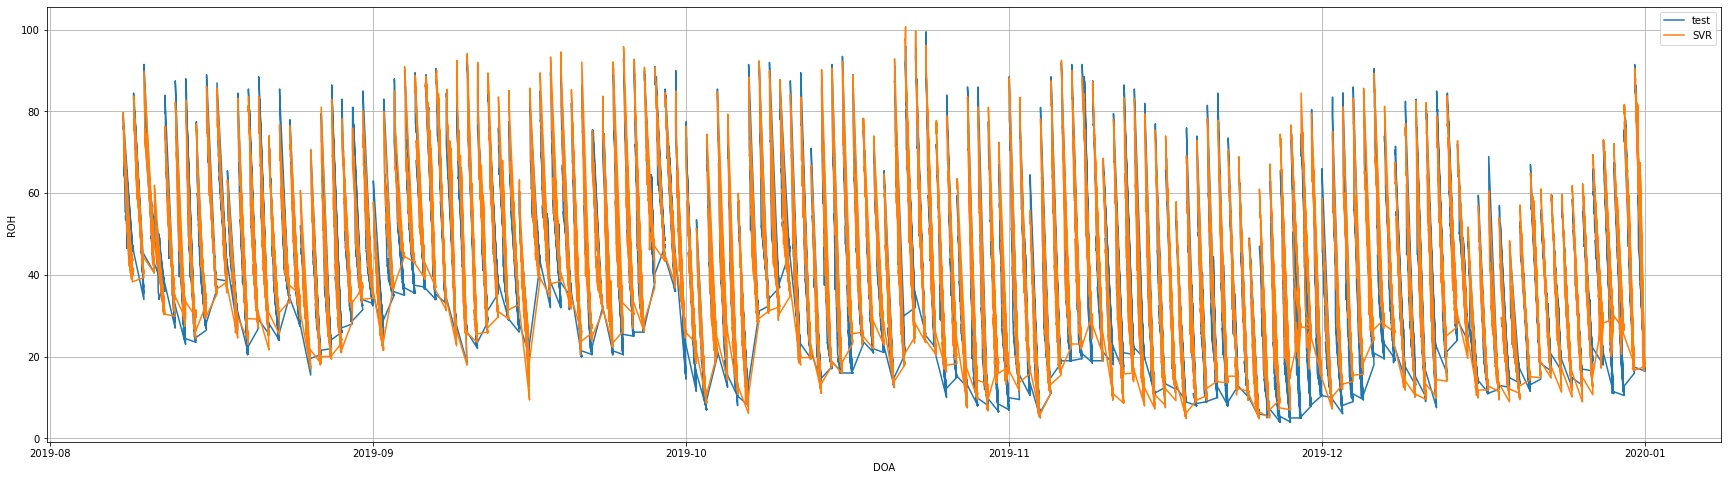

In [13]:
plot_result(test)

In [14]:
forecast_accuracy(test['PRED'],test['ROH'])

5.0602	&	-0.0465	&	3.9853	&	13.8936	&	5.0865	&	25.8726	&	0.9343


In [15]:
# Get numerical feature importances
importances = list(regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(test.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: ROH                  Importance: 0.8199
Variable: ROH_avg              Importance: 0.0724
Variable: ROH_min              Importance: 0.045
Variable: LAR_min              Importance: 0.016
Variable: Mon                  Importance: 0.0078
Variable: LAR_med              Importance: 0.0065
Variable: LAR_max              Importance: 0.006
Variable: DBA                  Importance: 0.0053
Variable: ROH_max              Importance: 0.0052
Variable: LAR_std              Importance: 0.0052
Variable: LAR_avg              Importance: 0.0043
Variable: DOW                  Importance: 0.0033
Variable: ROH_std              Importance: 0.0032


[None, None, None, None, None, None, None, None, None, None, None, None, None]

## With attributes

In [16]:
def colToRows(dx,attr):
    # DBA as attributes 
    dx = dx.pivot(index='DOA', columns='DBA', values=attr)
    # Removing sub index from Dataframe
    dx = dx.rename_axis(None, axis = 0)
    cols = {col:attr+str(int(col+1)).zfill(2) for col in dx.columns }
    # renaming columns
    dx = dx.rename(columns=cols)
    return dx.rename(columns={'ROH01':'ROH'}).sort_index(axis=1 ,ascending=False)

def preprocess(dx, cutoff = [0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]):
    dx = dx.rename(columns={'ROH_med':'ROH'})
    dx['DOA'] = pd.to_datetime(dx['DOA'])
    # dx['DBA'] = 89 - dx['DBA']
    dx = dx[dx.DBA.isin(cutoff)]
    # dx['OCC'] = dx['ROH']/dx['Rooms']

    attributes = ['LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'ROH_max', 'ROH_min', 'ROH_avg', 'ROH_std', 'ROH']
    result = pd.DataFrame()
    for attribute in attributes:
        temp = colToRows(dx,attribute)
        result = pd.concat([result, temp],axis=1)

    result['DOW'] = result.index.dayofweek
    result['Mon'] = result.index.month
    result['Day'] = result.index.day
    # standardizing prices
    scaler = StandardScaler()
    result[result.columns] = scaler.fit_transform(result[result.columns])

    return result

# Combined results

In [17]:
cuttoffs = [1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
for i in range(0,len(cuttoffs)):
    print('- DBA ',i)
    print([0]+cuttoffs[i:])

    df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')
    df = preprocess(df,[0]+cuttoffs[i:])
    train, test = train_test_split(df)
    cols = [col for col in df.columns if col != 'ROH']
    # creating model 
    y = train.pop('ROH')
    X = train
    # grid search best params
    regr = RandomForestRegressor(max_depth=1000, random_state=0)
    regr.fit(X, y)
    # grids.best_params_
    # print(grids.best_estimator_)
    # predict with best parameter
    test['PRED'] = regr.predict(test[cols])
    # plot 
    # plot_result(test)    
    # evaluation
    forecast_accuracy(test['PRED'],test['ROH'])

- DBA  0
[0, 1, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.0697	&	0.0275	&	0.0471	&	19.8929	&	0.0699	&	0.0049	&	0.9939
- DBA  1
[0, 2, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.1021	&	0.0793	&	0.068	&	31.6185	&	0.1021	&	0.0104	&	0.9869
- DBA  2
[0, 3, 4, 5, 6, 13, 20, 29, 59, 89]
0.1109	&	0.0761	&	0.0793	&	33.1404	&	0.1111	&	0.0123	&	0.9845
- DBA  3
[0, 4, 5, 6, 13, 20, 29, 59, 89]
0.121	&	-0.0159	&	0.0891	&	38.5007	&	0.1213	&	0.0147	&	0.9816
- DBA  4
[0, 5, 6, 13, 20, 29, 59, 89]
0.1387	&	-0.0352	&	0.1047	&	48.6682	&	0.1411	&	0.0199	&	0.9751
- DBA  5
[0, 6, 13, 20, 29, 59, 89]
0.1459	&	-0.029	&	0.1113	&	50.2146	&	0.1498	&	0.0224	&	0.9719
- DBA  6
[0, 13, 20, 29, 59, 89]
0.2596	&	0.1448	&	0.1861	&	61.2584	&	0.2692	&	0.0725	&	0.9092
- DBA  7
[0, 20, 29, 59, 89]
0.3317	&	0.3325	&	0.2502	&	89.7351	&	0.3451	&	0.1191	&	0.8509
- DBA  8
[0, 29, 59, 89]
0.3824	&	0.5872	&	0.3108	&	120.9638	&	0.4195	&	0.176	&	0.7796
- DBA  9
[0, 59, 89]
0.4965	&	0.397	&	0.3953	&	202.4365	&	0.5156	&	0.2659	&	0.667
- DBA  10
[0